# Gradient Descent

We will consider a linear model with two inputs and one binary output. In the first step we will derive, by hand, the equations for gradient descent for three different loss functions. Next, we will implement these two algorithms and run them on the iris dataset.

For a linear model $f(x) = x_1 * w_1 + x_2 * w_2 + b$ and a binary output $y$ ($y=0$ or $y=1$), let the cost function be $E(f(x), y)$.

The three cost functions we're considering are:

1) $E(f(x), y) = - I_{f(x) * y < 0} f(x) * y$ (similar to perceptron)

2) quadratic error $E(f(x), y) = \frac{1}{2} (f(x) - y)^2$

3) sigmoid cross entropy $E(f(x), y) = - y \ln (sigm(f(x))) - (1-y) \ln (1-sigm(f(x))$ where $sigm$ is the sigmoid function $sigm(x) = \frac{1}{1+e^{-x}}$.

## 1. Derivation

Derive, by hand, the equations for gradient descent (the gradient wrt the error) for each of the parameters ($w_1$, $w_2$, and $b$) for each of the three cost functions. What do you notice about 1)?

## 2. Implementation

### Data Preprocessing

For our binary classification problem, we will only use two classes: iris class 1 and 2. We will preprocess the dataset to extract only examples of these two classes, and for simplicity we will change their labels to be 1 and 0. As well, since we only have two inputs per example, we will only be using two features of each example.

Here is the code for the preprocessing:

In [1]:
%pylab inline
import numpy as np

iris = np.loadtxt('iris.txt')
data = iris

# extract only data with class label 1 or 2
data = data[data[:,-1]<3,:]

# change label 2 to be 0
data[data[:,-1]==2,-1] = 0

# we will use only features 2 and 3
train_cols = [2,3]

target_ind = [data.shape[1] - 1]

n_classes = 2
n_train = 75

# we set the random seed to make our results deterministic
# (same results across runs)
np.random.seed(2)

inds = np.arange(data.shape[0])
np.random.shuffle(inds)
train_inds = inds[:n_train]
test_inds = inds[n_train:]
    
# separate into train and test
train_set = data[train_inds,:] 
train_set = train_set[:,train_cols + target_ind]
test_set = data[test_inds,:]
test_set = test_set[:,train_cols + target_ind]

# normalize to mean 0 and standard deviation 1
mu1 = train_set[:,0].mean()
mu2 = train_set[:,1].mean()
sigma1 = train_set[:,0].std()
sigma2 = train_set[:,1].std()
train_set[:,0] -= mu1
train_set[:,1] -= mu2
train_set[:,0] /= sigma1
train_set[:,1] /= sigma2
test_set[:,0] -= mu1
test_set[:,1] -= mu2
test_set[:,0] /= sigma1
test_set[:,1] /= sigma2

# split into inputs and labels
train_inputs = train_set[:,:-1]
train_labels = train_set[:,-1]
test_inputs = test_set[:,:-1]
test_labels = test_set[:,-1]


# the base class of our models
class Model:

    def plot_function(self, train_data, title):
        plt.figure()
        d1 = train_data[train_data[:, -1] > 0]
        d2 = train_data[train_data[:, -1] == 0]
        plt.scatter(d1[:, 0], d1[:, 1], c='b', label='class 1')
        plt.scatter(d2[:, 0], d2[:, 1], c='g', label='class 0')
        x = np.linspace(-10, 10, 100)
        y = (0.5 - self.weights[0][0]*x - self.bias)/self.weights[0][1]
        plt.plot(x, y, c='r', lw=2, label='y = (0.5 - w1*x - b1)/w2')
        plt.xlim(np.min(train_data[:, 0]) - 0.5, np.max(train_data[:, 0]) + 0.5)
        plt.ylim(np.min(train_data[:, 1]) - 0.5, np.max(train_data[:, 1]) + 0.5)
        plt.grid()
        plt.legend(loc='lower right')
        plt.title(title)
        plt.show()

Populating the interactive namespace from numpy and matplotlib


## LinearRegression and SigmoidCrossEntropy

We introduce the classes *LinearRegression* (quadratic error) and *SigmoidCrossEntropy* (sigmoid cross-entropy). As usual, there is a *train* method to train on the train set, and a *compute_predictions* method which computes predictions for the test set

Using the gradients we computed earlier, write the training loop for each of the classes in *train* and write the predictions computation in *compute_predictions* (remember to use *self.max_iter* to make sure that your algorithm doesn't run forever)

In [37]:
class LinearRegression(Model):
    def __init__(self, alpha, max_iter):
        self.alpha = alpha
        self.max_iter = max_iter
    
    def train(self, inputs, labels):
        self.weights = np.random.rand(inputs.shape[1]).reshape(1,inputs.shape[1])/100
        self.bias = np.zeros(1)
        iteration = 0
        while (iteration < self.max_iter):
            iteration += 1
            error = (np.sum(self.weights * inputs, axis = 1) + self.bias - labels).reshape(inputs.shape[0],1)
            self.weights = self.weights - self.alpha * np.mean(error * inputs, axis = 0)
            self.bias = self.bias - self.alpha * np.mean(error, axis = 0)
        print(self.weights)
        print(self.bias)
            
    def compute_predictions(self, test_inputs):
        return np.sum(self.weights * test_inputs, axis = 1) + self.bias

def sigmoid(x):
    return (1. + np.exp(-x))**(-1)

def sigmoid_deriv(x):
    return np.exp(-x) * (1. + np.exp(-x))**(-2)
    
class SigmoidCrossEntropy(Model):
    def __init__(self, alpha, max_iter):
        self.alpha = alpha
        self.max_iter = max_iter
    
    def train(self, inputs, labels):
        self.weights = np.random.rand(inputs.shape[1]).reshape(1,inputs.shape[1])/100
        self.bias = np.zeros(1)
        labels = labels.reshape(labels.shape[0],1)
        iteration = 0
        while (iteration < self.max_iter):
            iteration += 1
            f_x = (np.sum(self.weights * inputs, axis = 1) + self.bias).reshape(inputs.shape[0],1)
            #print(self.objective_function(f_x, inputs, labels))
            #print(inputs.shape)
            #delta_w = np.mean(inputs * sigmoid_deriv(f_x) * (- labels * np.absolute(sigmoid(f_x))**(-1) - (1. - labels) * np.absolute(1. - sigmoid(f_x))**(-1)), axis = 0)
            #delta_b = np.mean(sigmoid_deriv(f_x) * (- labels * np.absolute(sigmoid(f_x))**(-1) - (1. - labels) * np.absolute(1. - sigmoid(f_x))**(-1)), axis = 0)
            delta_w = np.mean(inputs * (-labels * (np.exp(f_x) + 1)**(-1) - (1 - labels) * (1 + np.exp(f_x))**(-1)), axis = 0)
            delta_b = np.mean(-labels * (np.exp(f_x) + 1)**(-1) - (1 - labels) * (1 + np.exp(f_x))**(-1), axis = 0)
            #print(delta_w.shape)
            self.weights = self.weights - self.alpha * delta_w
            self.bias = self.bias - self.alpha * delta_b
        print(self.weights)
        print(self.bias)
        print(self.objective_function(f_x, inputs, labels))
    
    def objective_function(self, f_x, inputs, labels):
        return np.sum(-labels * np.log(sigmoid(f_x)) - (1 - labels) * np.log(1 - sigmoid(f_x)))
    
    def compute_predictions(self, test_inputs):
        return np.sum(self.weights * test_inputs, axis = 1) + self.bias

### Train and Test

Once the classes above are complete, run the code below to train and test your models

[[-0.24955529 -0.23479466]]
[0.45035471]


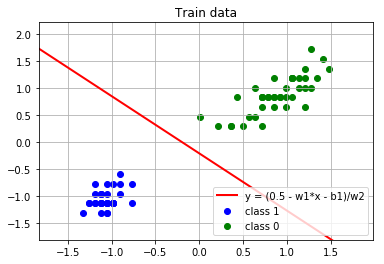

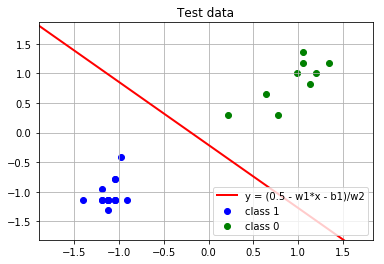

Test error is  0.0 %


In [3]:
# learning rate
alpha = 0.01

# max number of iteration
max_iter = 500

# create and train the model
model = LinearRegression(alpha, max_iter)
model.train(train_inputs, train_labels)
model.plot_function(train_set, 'Train data')

# predict the class for the test examples
predictions = model.compute_predictions(test_inputs)
# convert the predictions to either false (0) or true (1)
classes_pred = predictions > 0.5
   
# calculate error
err = 1.0 - np.mean(test_labels==classes_pred)

model.plot_function(test_set, 'Test data')
print("Test error is ", 100.0 * err,"%") 

[[-0.00116793  0.00137015]]
[2.17813589]
97.32299438799657


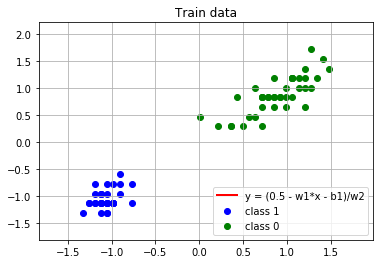

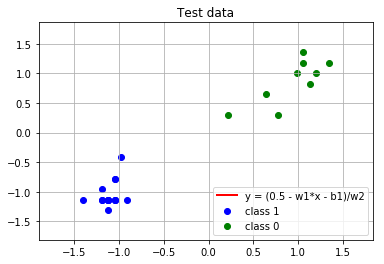

Test error is  36.0 %


In [38]:
# create and train the model
max_iter = 1000
model = SigmoidCrossEntropy(alpha, max_iter)
model.train(train_inputs, train_labels)
model.plot_function(train_set, 'Train data')

# predict the class for the test examples
predictions = model.compute_predictions(test_inputs)
# convert the predictions to either false (0) or true (1)
classes_pred = predictions > 0.5
   
# calculate error
err = 1.0 - np.mean(test_labels==classes_pred)

model.plot_function(test_set, 'Test data')
print("Test error is ", 100.0 * err,"%" )